In [74]:
import json
from tqdm.notebook import tqdm

In [75]:
import numpy as np

from torch_geometric.data import HeteroData, Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear
import torch

In [ ]:
# Seq pos is 27:156; aka, reactivity comes from positions 27 through 156 in the sequence

In [4]:
with open('mxfold2_results.json','r') as f:
    fold_data = json.load(f)

In [5]:
with open('filtered_pdb_with_reads.json','r') as f:
    muts_data = json.load(f)

In [6]:
with open('FR3D_annotations.json','r') as f:
    FR3D_data = json.load(f)

In [7]:
missing_keys = []
key_list = []
for k,v in tqdm(muts_data.items()):
    try:
        FR3D_data[k]
        fold_data[k]
        key_list += [k]
    except:
        missing_keys += [k]

  0%|          | 0/1286 [00:00<?, ?it/s]

In [8]:
nuc_dict = {
    'A':torch.tensor([1,0,0,0]),
    'U':torch.tensor([0,1,0,0]),
    'G':torch.tensor([0,0,1,0]),
    'C':torch.tensor([0,0,0,1]),
}

In [59]:
def clipEdges(edge_list, indices):
    return edge_list[np.where(((edge_list >= indices[0]) & (edge_list < indices[1])).sum(axis=1)==2)]

In [97]:
all_data = []

for key in tqdm(key_list):
    
    hetdata = HeteroData()
    
    local_FR3D_data = FR3D_data[key]
    local_muts_data = muts_data[key]
    local_fold_data = fold_data[key]

    indices = local_FR3D_data['fasta_idxs']
    seq = local_muts_data['sequence'][slice(*indices)]
    X = np.array([nuc_dict.get(nt,torch.zeros(4)) for nt in seq])
    X = np.hstack((X,np.array([local_muts_data['2A3_values'][slice(indices[0]-26,indices[1]-26)],
                               local_muts_data['DMS_values'][slice(indices[0]-26,indices[1]-26)]]).T))

    mxfold_edgelist = np.array(local_fold_data['mxfold2_edge_list'])
    mxfold_edgelist = clipEdges(mxfold_edgelist, indices) - indices[0]

    FR3D_edgelist = np.array(local_FR3D_data['FR3D_edge_list'])
    FR3D_edgelist -= FR3D_edgelist.min()
    FR3D_edgelist += local_FR3D_data['FR3D_idxs'][0]

    mxfold_edgelist = clipEdges(mxfold_edgelist, [0,len(X)])
    mxfold_edgelist = np.vstack((mxfold_edgelist,mxfold_edgelist[:,::-1]))
    FR3D_edgelist = clipEdges(FR3D_edgelist, [0,len(X)])
        
    hetdata['nuc'].x = torch.tensor(np.nan_to_num(X,nan=0),dtype=torch.float)
    hetdata['nuc','mxfold','nuc'].edge_index = torch.tensor(mxfold_edgelist).T
    hetdata['nuc','FR3D','nuc'].edge_index = torch.tensor(FR3D_edgelist).T
    hetdata['nuc','connected','nuc'].edge_index = torch.tensor(
        [[i,i+1] for i in range(len(seq)-1)] + [[i+1,i] for i in range(len(seq)-1)]
    ).T

    hetdata[('nuc', 'neg_FR3D', 'nuc')].edge_index = negative_sampling(
                    edge_index = hetdata[('nuc', 'FR3D', 'nuc')].edge_index,
                    num_nodes = hetdata.num_nodes
                    ).type(torch.int)
    all_data += [hetdata]

  0%|          | 0/1232 [00:00<?, ?it/s]

In [98]:
with open('Compiled_data.dat','wb') as f:
    torch.save(all_data,f)

In [76]:
with open('Compiled_data.dat','rb') as f:
    reload_data = torch.load(f)

C:\Users\jshin\AppData\Local\Temp\ipykernel_12660\3613182026.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reload_data = torch.load(f)


In [77]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

In [78]:
def makeSubgraph(G,edge_types): 
    return nx.Graph([(u, v, e) for u,v,e in G.edges(data=True) if e['type'] in edge_types])

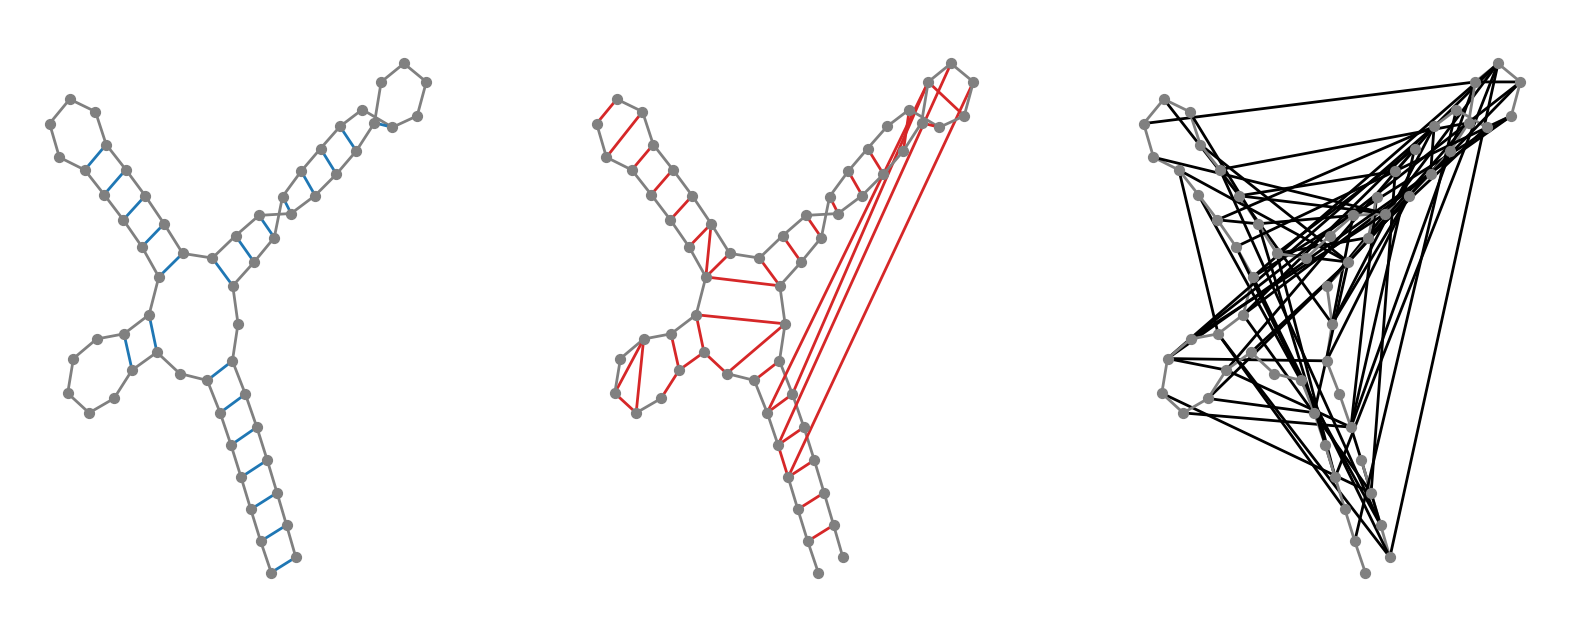

In [88]:

fig,axs = plt.subplots(ncols=3,figsize=(20,8))
edge_color_dict = {('nuc', 'connected', 'nuc'):'grey', 
                   ('nuc', 'mxfold', 'nuc'):'tab:blue', 
                   ('nuc', 'FR3D', 'nuc'):'tab:red',
                   ('nuc', 'neg_FR3D', 'nuc'):'k'
}

G = to_networkx(reload_data[20],to_multi=True)
H = makeSubgraph(G,[('nuc', 'connected', 'nuc'),('nuc', 'mxfold', 'nuc')])
pos=nx.spring_layout(H)
pos=nx.kamada_kawai_layout(H,pos=pos)

for from_node, to_node, attrs in G.edges(data=True):
    edge_type = attrs['type']
    if G.edges[from_node,to_node,0]['type'] == edge_type:
        k = 0
    else:
        k = 1
    color = edge_color_dict[edge_type]
    G.edges[from_node, to_node, k]['color'] = color
    
H = makeSubgraph(G,[('nuc', 'connected', 'nuc'),('nuc', 'mxfold', 'nuc')])
nx.draw(H, pos=pos, node_color="grey",node_size=50,width=2,
    edge_color=[e['color'] for u,v,e in H.edges(data=True)],ax=axs[0])

H = makeSubgraph(G, [('nuc', 'connected', 'nuc'),('nuc', 'FR3D', 'nuc')])
nx.draw(H, pos=pos, node_color="grey",node_size=50,width=2,
    edge_color=[e['color'] for u,v,e in H.edges(data=True)],ax=axs[1])

H = makeSubgraph(G, [('nuc', 'connected', 'nuc'),('nuc', 'neg_FR3D', 'nuc')])
nx.draw(H, pos=pos, node_color="grey",node_size=50,width=2,
    edge_color=[e['color'] for u,v,e in H.edges(data=True)],ax=axs[2])

plt.show()

In [91]:
reload_data[20]

HeteroData(
  nuc={ x=[60, 6] },
  (nuc, mxfold, nuc)={ edge_index=[2, 44] },
  (nuc, FR3D, nuc)={ edge_index=[2, 67] },
  (nuc, connected, nuc)={ edge_index=[2, 59] },
  (nuc, neg_FR3D, nuc)={ edge_index=[2, 67] }
)

In [99]:
np.sum([d['nuc']['x'].shape[0] for d in reload_data])

86169

In [101]:
np.sum([d[('nuc', 'mxfold', 'nuc')]['edge_index'].shape[1] for d in reload_data])

45060

In [102]:
np.sum([d[('nuc', 'FR3D', 'nuc')]['edge_index'].shape[1] for d in reload_data])

88273

In [103]:
np.sum([d[('nuc', 'connected', 'nuc')]['edge_index'].shape[1] for d in reload_data])

84937